<a href="https://colab.research.google.com/github/data-in-galaxy/Finetuning-LLM/blob/main/finetuning_llms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is finetuning?

Customizes a foundation model to a specific use cases



# Tasks to finetune

- Extraction: text in, less text out
  + "Reading"
  + Keywords, topics, etc.

- Expansion: text in, more text out
  + "Writing"
  + Chat, write emails, write code


# First-time finetuning

1. Identify tasks by prompt engineering a large LLM

2. Find tasks that you see an LLM doing OK at

3. Pick one task

4. Get ~1000 ideal pairs of inputs & outputs for the task

5. Finetune a small LLM on this data

In [ ]:
!pip install jsonlines
import jsonlines
import itertools
import pandas as pd
from pprint import pprint

!pip install datasets
import datasets
from datasets import load_dataset

In [2]:
# Load in "Common Crawl" dataset - can be used to train base model
pretrained_dataset = load_dataset("c4", "en", split="train", streaming=True)

In [3]:
n = 5
print("Pretrained dataset:")
top_n = itertools.islice(pretrained_dataset, n)
for i in top_n:
  print(i)

Pretrained dataset:
{'text': 'Beginners BBQ Class Taking Place in Missoula!\nDo you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.\nHe will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.\nThe cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.', 'timestamp': '2019-04-25T12:57:54Z', 'url': 'https://klyq.com/beginners-bbq-class-taking-place-in-missoula/'}
{'text': 'Discussion in \'Mac OS X Lion (10.7)\' started by axboi87, Jan 20, 2012.\nI\'ve got a 500gb inter

## Load company finetuned dataset

In [4]:
from google.colab import files
uploaded = files.upload()

Saving lamini_docs.jsonl to lamini_docs.jsonl


In [7]:
filename = "lamini_docs.jsonl"

instruction_dataset_df = pd.read_json(filename, lines=True)
instruction_dataset_df

,question,answer
0,What are the different types of documents avai...,"Lamini has documentation on Getting Started, A..."
1,What is the recommended way to set up and conf...,Lamini can be downloaded as a python package a...
2,How can I find the specific documentation I ne...,"You can ask this model about documentation, wh..."
3,Does the documentation include explanations of...,Our documentation provides both real-world and...
4,Does the documentation provide information abo...,External dependencies and libraries are all av...
...,...,...
1395,What is Lamini and what is its collaboration w...,Lamini is a library that simplifies the proces...
1396,How does Lamini simplify the process of access...,Lamini simplifies data access in Databricks by...
1397,What are some of the key features provided by ...,Lamini automatically manages the infrastructur...
1398,How does Lamini ensure data privacy during the...,"During the training process, Lamini ensures da..."


## Format finetuning data

Concatenate "question"-"answer" pairs

In [8]:
examples = instruction_dataset_df.to_dict()
text = examples["question"][0] + examples["answer"][0]
text

"What are the different types of documents available in the repository (e.g., installation guide, API documentation, developer's guide)?Lamini has documentation on Getting Started, Authentication, Question Answer Model, Python Library, Batching, Error Handling, Advanced topics, and class documentation on LLM Engine available at https://lamini-ai.github.io/."

In [ ]:
# Multiple ways to concatenate the data pairs
'''
if "question" in examples and "answer" in examples:
  text = examples["question"][0] + examples["answer"][0]
elif "instruction" in examples and "response" in examples:
  text = examples["instruction"][0] + examples["response"][0]
elif "input" in examples and "output" in examples:
  text = examples["input"][0] + examples["output"][0]
else:
  text = examples["text"][0]
'''

In [9]:
# Create Question-Answer prompt to format data
prompt_template_qa = """### Question:
{question}

### Answer:
{answer}"""

In [10]:
question = examples["question"][0]
answer = examples["answer"][0]

text_with_prompt_template = prompt_template_qa.format(question=question, answer=answer)
text_with_prompt_template

"### Question:\nWhat are the different types of documents available in the repository (e.g., installation guide, API documentation, developer's guide)?\n\n### Answer:\nLamini has documentation on Getting Started, Authentication, Question Answer Model, Python Library, Batching, Error Handling, Advanced topics, and class documentation on LLM Engine available at https://lamini-ai.github.io/."

In [11]:
# Format only the question part
prompt_template_q = """### Question:
{question}

### Answer:"""

In [13]:
# Combine it all together
num_examples = len(examples["question"])
finetuning_dataset_text_only = []
finetuning_dataset_question_answer = []
for i in range(num_examples):
  question = examples["question"][i]
  answer = examples["answer"][i]

  text_with_prompt_template_qa = prompt_template_qa.format(question=question, answer=answer)
  finetuning_dataset_text_only.append({"text": text_with_prompt_template_qa})

  text_with_prompt_template_q = prompt_template_q.format(question=question)
  finetuning_dataset_question_answer.append({"question": text_with_prompt_template_q, "answer": answer})

In [14]:
pprint(finetuning_dataset_text_only[0])

{'text': '### Question:\n'
         'What are the different types of documents available in the '
         "repository (e.g., installation guide, API documentation, developer's "
         'guide)?\n'
         '\n'
         '### Answer:\n'
         'Lamini has documentation on Getting Started, Authentication, '
         'Question Answer Model, Python Library, Batching, Error Handling, '
         'Advanced topics, and class documentation on LLM Engine available at '
         'https://lamini-ai.github.io/.'}


In [15]:
pprint(finetuning_dataset_question_answer[0]) # more structured

{'answer': 'Lamini has documentation on Getting Started, Authentication, '
           'Question Answer Model, Python Library, Batching, Error Handling, '
           'Advanced topics, and class documentation on LLM Engine available '
           'at https://lamini-ai.github.io/.',
 'question': '### Question:\n'
             'What are the different types of documents available in the '
             'repository (e.g., installation guide, API documentation, '
             "developer's guide)?\n"
             '\n'
             '### Answer:'}


## Ways to store finetuning data

Can upload to Hugging Face

In [16]:
with jsonlines.open(f'lamini_docs_processed.jsonl', 'w') as writer:
    writer.write_all(finetuning_dataset_question_answer)

In [17]:
# Code below is for download the uploaded dataset from HuggingFace
finetuning_dataset_name = "lamini/lamini_docs"
finetuning_dataset = load_dataset(finetuning_dataset_name)
print(finetuning_dataset)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1260 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/140 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1260
    })
    test: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 140
    })
})


## Instruction Tuning

A type of finetuning - teaches LLM to behave like chatbot

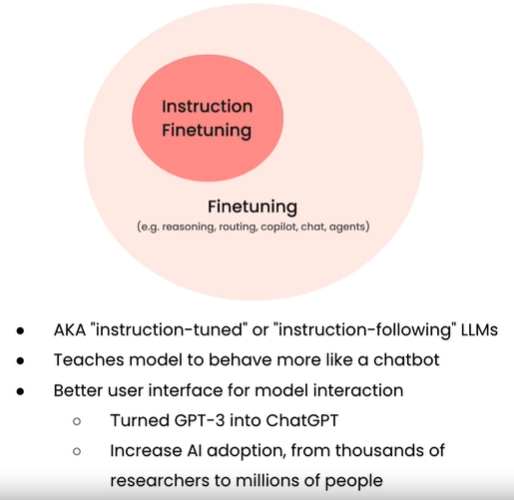

**Dataset**
Typically Q&A dataset:

- FAQs
- Customer support conversations
- Slack messages

### Workflow

1. Data Prep
- Vary by different tasks of finetuning<br>
<br>
2. Training
- Similar across tasks<br>
<br>
3. Evaluation
- Similar across tasks

In [ ]:
import itertools
!pip install jsonlines
import jsonlines

!pip install datasets
from datasets import load_dataset
from pprint import pprint

!pip install transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

#### Load instruction tuned dataset

In [3]:
instruction_tuned_dataset = load_dataset("tatsu-lab/alpaca", split="train", streaming=True)

In [4]:
m = 5
print("Instruction-tuned dataset:")
top_m = list(itertools.islice(instruction_tuned_dataset, m))
for j in top_m:
  print(j)

Instruction-tuned dataset:
{'instruction': 'Give three tips for staying healthy.', 'input': '', 'output': '1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.', 'text': 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nGive three tips for staying healthy.\n\n### Response:\n1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.'}
{'instruction': 'What are the three primary colors?', 'input': '', 'output': 'The three primary colors are red, blue, and yellow.', 'text': 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat are the three p

#### Two prompt templates

In [5]:
prompt_template_with_input = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Input:
{input}

### Response:"""

prompt_template_without_input = """Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Response:"""

#### Add data to prompts

In [6]:
processed_data = []
for j in top_m:
  if not j["input"]:
    processed_prompt = prompt_template_without_input.format(instruction=j["instruction"])
  else:
    processed_prompt = prompt_template_with_input.format(instruction=j["instruction"], input=j["input"])

  processed_data.append({"input": processed_prompt, "output": j["output"]})

In [7]:
pprint(processed_data[0])

{'input': 'Below is an instruction that describes a task. Write a response '
          'that appropriately completes the request.\n'
          '\n'
          '### Instruction:\n'
          'Give three tips for staying healthy.\n'
          '\n'
          '### Response:',
 'output': '1.Eat a balanced diet and make sure to include plenty of fruits '
           'and vegetables. \n'
           '2. Exercise regularly to keep your body active and strong. \n'
           '3. Get enough sleep and maintain a consistent sleep schedule.'}


#### Save data to jsonl

In [8]:
with jsonlines.open(f'alpaca_processed.jsonl', 'w') as writer:
    writer.write_all(processed_data)

In [ ]:
# alpaca dataset uploaded on huggingface
'''
dataset_path_hf = "lamini/alpaca"
dataset_hf = load_dataset(dataset_path_hf)
print(dataset_hf)
'''

### Compare non-instruction-tuned vs instruction-tuned models

In [9]:
from transformers import pipeline

In [ ]:
'''
non_instruct_model = pipeline(model="meta-llama/Llama-2-7b-hf")
non_instruct_output = non_instruct_model("Tell me how to train my dog to sit")
print("Not instruction-tuned output (Llama 2 Base):", non_instruct_output)
'''

In [ ]:
'''
instruct_model = pipeline(model="meta-llama/Llama-2-7b-chat-hf")
instruct_output = instruct_model("Tell me how to train my dog to sit")
print("Instruction-tuned output (Llama 2): ", instruct_output)
'''

### Load smaller models

In [12]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")
model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-70m")

(…)a-70m/resolve/main/tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

(…)I/pythia-70m/resolve/main/tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

(…)70m/resolve/main/special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

(…)erAI/pythia-70m/resolve/main/config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

In [13]:
def inference(text, model, tokenizer, max_input_tokens=1000, max_output_tokens=100):
  # Tokenize
  input_ids = tokenizer.encode(
          text,
          return_tensors="pt",
          truncation=True,
          max_length=max_input_tokens
  )

  # Generate
  device = model.device
  generated_tokens_with_prompt = model.generate(
    input_ids=input_ids.to(device),
    max_length=max_output_tokens
  )

  # Decode
  generated_text_with_prompt = tokenizer.batch_decode(generated_tokens_with_prompt, skip_special_tokens=True)

  # Strip the prompt
  generated_text_answer = generated_text_with_prompt[0][len(text):]

  return generated_text_answer

In [14]:
finetuning_dataset_path = "lamini/lamini_docs"
finetuning_dataset = load_dataset(finetuning_dataset_path)
print(finetuning_dataset)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1260 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/140 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1260
    })
    test: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 140
    })
})


In [15]:
test_sample = finetuning_dataset["test"][0]
print(test_sample)

print(inference(test_sample["question"], model, tokenizer))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


{'question': 'Can Lamini generate technical documentation or user manuals for software projects?', 'answer': 'Yes, Lamini can generate technical documentation and user manuals for software projects. It uses natural language generation techniques to create clear and concise documentation that is easy to understand for both technical and non-technical users. This can save developers a significant amount of time and effort in creating documentation, allowing them to focus on other aspects of their projects.', 'input_ids': [5804, 418, 4988, 74, 6635, 7681, 10097, 390, 2608, 11595, 84, 323, 3694, 6493, 32, 4374, 13, 418, 4988, 74, 476, 6635, 7681, 10097, 285, 2608, 11595, 84, 323, 3694, 6493, 15, 733, 4648, 3626, 3448, 5978, 5609, 281, 2794, 2590, 285, 44003, 10097, 326, 310, 3477, 281, 2096, 323, 1097, 7681, 285, 1327, 14, 48746, 4212, 15, 831, 476, 5321, 12259, 247, 1534, 2408, 273, 673, 285, 3434, 275, 6153, 10097, 13, 6941, 731, 281, 2770, 327, 643, 7794, 273, 616, 6493, 15], 'attention

### Compare to finetuned small model

In [16]:
instruction_model = AutoModelForCausalLM.from_pretrained("lamini/lamini_docs_finetuned")

(…)_docs_finetuned/resolve/main/config.json:   0%|          | 0.00/717 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/282M [00:00<?, ?B/s]

(…)uned/resolve/main/generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [17]:
print(inference(test_sample["question"], instruction_model, tokenizer))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Yes, Lamini can generate technical documentation or user manuals for software projects. This can be achieved by providing a prompt for a specific technical question or question to the LLM Engine, or by providing a prompt for a specific technical question or question. Additionally, Lamini can be trained on specific technical questions or questions to help users understand the process and provide feedback to the LLM Engine. Additionally, Lamini


In [ ]:
# Upload instruction tuned dataset to Huggingface

# !pip install huggingface_hub
# !huggingface-cli login

# import pandas as pd
# import datasets
# from datasets import Dataset

# finetuning_dataset = Dataset.from_pandas(pd.DataFrame(data=finetuning_dataset))
# finetuning_dataset.push_to_hub(dataset_path_hf)

### Instruction Tuning: Data Preparation

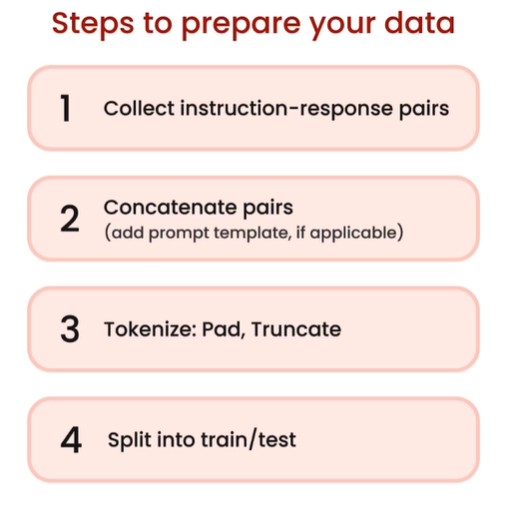

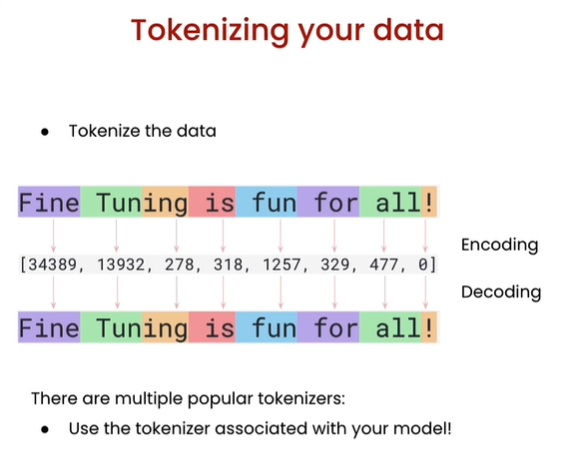


In [4]:
import pandas as pd
!pip install datasets transformers
import datasets

from pprint import pprint
from transformers import AutoTokenizer # Auto find the right tokenizer for the model

#### Tokenize Text

In [5]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")

In [6]:
text = "Hi, how are you?"

In [7]:
encoded_text = tokenizer(text)["input_ids"]

In [8]:
encoded_text

[12764, 13, 849, 403, 368, 32]

In [9]:
# Decode back into text
decoded_text = tokenizer.decode(encoded_text)
print("Decoded tokens back into text: ", decoded_text)

Decoded tokens back into text:  Hi, how are you?


In [10]:
# Tokenize multiple texts at once
list_texts = ["Hi, how are you?", "I'm good", "Yes"]
encoded_texts = tokenizer(list_texts)
print("Encoded several texts: ", encoded_texts["input_ids"])

Encoded several texts:  [[12764, 13, 849, 403, 368, 32], [42, 1353, 1175], [4374]]


#### Padding

Strategy to make every piece of text in a batch to be of same size

- Pad 0s or end-of-sentence token to ensure all encoded text are of same size

In [11]:
tokenizer.pad_token = tokenizer.eos_token
encoded_texts_longest = tokenizer(list_texts, padding=True)
print("Using padding: ", encoded_texts_longest["input_ids"])

# "yes" string is now of the same size as "Hi, how are you?" string

Using padding:  [[12764, 13, 849, 403, 368, 32], [42, 1353, 1175, 0, 0, 0], [4374, 0, 0, 0, 0, 0]]


#### Truncate

Shorten encoded text to fit within length limit

- Can specify side of truncation (right or left) to retain important information on either side

In [12]:
encoded_texts_truncation = tokenizer(list_texts, max_length=3, truncation=True)
print("Using truncation: ", encoded_texts_truncation["input_ids"])

Using truncation:  [[12764, 13, 849], [42, 1353, 1175], [4374]]


In [13]:
tokenizer.truncation_side = "left" # specify truncation size
encoded_texts_truncation_left = tokenizer(list_texts, max_length=3, truncation=True)
print("Using left-side truncation: ", encoded_texts_truncation_left["input_ids"])

Using left-side truncation:  [[403, 368, 32], [42, 1353, 1175], [4374]]


In [14]:
# using both padding & truncation
encoded_texts_both = tokenizer(list_texts, max_length=3, truncation=True, padding=True)
print("Using both padding and truncation: ", encoded_texts_both["input_ids"])

Using both padding and truncation:  [[403, 368, 32], [42, 1353, 1175], [4374, 0, 0]]


##### Prepare real data for tuning

In [15]:
# Load data
from google.colab import files
uploaded = files.upload()

Saving lamini_docs.jsonl to lamini_docs.jsonl


In [16]:
filename = "lamini_docs.jsonl"

instruction_dataset_df = pd.read_json(filename, lines=True)
examples = instruction_dataset_df.to_dict()

In [17]:
# Concatenate question-answer pair
if "question" in examples and "answer" in examples:
  text = examples["question"][0] + examples["answer"][0]
elif "instruction" in examples and "response" in examples:
  text = examples["instruction"][0] + examples["response"][0]
elif "input" in examples and "output" in examples:
  text = examples["input"][0] + examples["output"][0]
else:
  text = examples["text"][0]

# Define prompt template
prompt_template = """### Question:
{question}

### Answer:"""

# Add data to the prompt
num_examples = len(examples["question"])
finetuning_dataset = []
for i in range(num_examples):
  question = examples["question"][i]
  answer = examples["answer"][i]
  text_with_prompt_template = prompt_template.format(question=question)
  finetuning_dataset.append({"question": text_with_prompt_template, "answer": answer})

from pprint import pprint
print("One datapoint in the finetuning dataset:")
pprint(finetuning_dataset[0])

One datapoint in the finetuning dataset:
{'answer': 'Lamini has documentation on Getting Started, Authentication, '
           'Question Answer Model, Python Library, Batching, Error Handling, '
           'Advanced topics, and class documentation on LLM Engine available '
           'at https://lamini-ai.github.io/.',
 'question': '### Question:\n'
             'What are the different types of documents available in the '
             'repository (e.g., installation guide, API documentation, '
             "developer's guide)?\n"
             '\n'
             '### Answer:'}


In [18]:
# Tokenize a single datapoint
text = finetuning_dataset[0]["question"] + finetuning_dataset[0]["answer"] # concatenate the question-answer pair
tokenized_inputs = tokenizer(
    text,
    return_tensors="np", # return tensors as numpy array
    padding=True
)
print(tokenized_inputs["input_ids"])

[[ 4118 19782    27   187  1276   403   253  1027  3510   273  7177  2130
    275   253 18491   313    70    15    72   904 12692  7102    13  8990
  10097    13 13722   434  7102  6177   187   187  4118 37741    27    45
   4988    74   556 10097   327 27669 11075   264    13  5271 23058    13
  19782 37741 10031    13 13814 11397    13   378 16464    13 11759 10535
   1981    13 21798 12989    13   285   966 10097   327 21708    46 10797
   2130   387  5987  1358    77  4988    74    14  2284    15  7280    15
    900 14206]]


In [19]:
max_length = 2048
max_length = min(
    tokenized_inputs["input_ids"].shape[1],
    max_length,
)

In [20]:
# Tokenize with truncation
tokenized_inputs = tokenizer(
    text,
    return_tensors="np",
    truncation=True,
    max_length=max_length
)

In [21]:
tokenized_inputs["input_ids"]

array([[ 4118, 19782,    27,   187,  1276,   403,   253,  1027,  3510,
          273,  7177,  2130,   275,   253, 18491,   313,    70,    15,
           72,   904, 12692,  7102,    13,  8990, 10097,    13, 13722,
          434,  7102,  6177,   187,   187,  4118, 37741,    27,    45,
         4988,    74,   556, 10097,   327, 27669, 11075,   264,    13,
         5271, 23058,    13, 19782, 37741, 10031,    13, 13814, 11397,
           13,   378, 16464,    13, 11759, 10535,  1981,    13, 21798,
        12989,    13,   285,   966, 10097,   327, 21708,    46, 10797,
         2130,   387,  5987,  1358,    77,  4988,    74,    14,  2284,
           15,  7280,    15,   900, 14206]])

In [22]:
# Tokenize the entire dataset
def tokenize_function(examples):
    if "question" in examples and "answer" in examples:
      text = examples["question"][0] + examples["answer"][0]
    elif "input" in examples and "output" in examples:
      text = examples["input"][0] + examples["output"][0]
    else:
      text = examples["text"][0]

    tokenizer.pad_token = tokenizer.eos_token
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        padding=True,
    )

    max_length = min(
        tokenized_inputs["input_ids"].shape[1],
        2048
    )
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        max_length=max_length
    )

    return tokenized_inputs

In [23]:
finetuning_dataset_loaded = datasets.load_dataset("json", data_files=filename, split="train")

tokenized_dataset = finetuning_dataset_loaded.map(
    tokenize_function,
    batched=True,
    batch_size=1,
    drop_last_batch=True # help with mixed size inputs
)

print(tokenized_dataset)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask'],
    num_rows: 1400
})


In [24]:
tokenized_dataset = tokenized_dataset.add_column("labels", tokenized_dataset["input_ids"])

In [25]:
print(tokenized_dataset)

Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1400
})


#### Split train/test sets

In [26]:
split_dataset = tokenized_dataset.train_test_split(test_size=0.1, shuffle=True, seed=123)
print(split_dataset)

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1260
    })
    test: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 140
    })
})


In [27]:
from datasets import DatasetDict

if isinstance(split_dataset, DatasetDict):
    print("split_dataset is a Hugging Face DatasetDict.")
else:
    print("split_dataset is not a Hugging Face DatasetDict.")

split_dataset is a Hugging Face DatasetDict.


#### Other datasets to try

In [88]:
taylor_swift_dataset = "lamini/taylor_swift"
bts_dataset = "lamini/bts"
open_llms = "lamini/open_llms"

In [28]:
dataset_swiftie = datasets.load_dataset(taylor_swift_dataset)
print(dataset_swiftie["train"][1])

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/783 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/87 [00:00<?, ? examples/s]

{'question': 'What is the most popular Taylor Swift song among millennials? How does this song relate to the millennial generation? What is the significance of this song in the millennial culture?', 'answer': 'Taylor Swift\'s "Shake It Off" is the most popular song among millennials. This song relates to the millennial generation as it is an anthem of self-acceptance and embracing one\'s individuality. The song\'s message of not letting others bring you down and to just dance it off resonates with the millennial culture, which is often characterized by a strong sense of individuality and a rejection of societal norms. Additionally, the song\'s upbeat and catchy melody makes it a perfect fit for the millennial generation, which is known for its love of pop music.', 'input_ids': [1276, 310, 253, 954, 4633, 11276, 24619, 4498, 2190, 24933, 8075, 32, 1359, 1057, 436, 4498, 14588, 281, 253, 24933, 451, 5978, 32, 1737, 310, 253, 8453, 273, 436, 4498, 275, 253, 24933, 451, 4466, 32, 37979, 24

In [ ]:
# This is how to push your own dataset to your Huggingface hub
# !pip install huggingface_hub
# !huggingface-cli login
# split_dataset.push_to_hub(dataset_path_hf)

### Intruction Tuning: Training Process

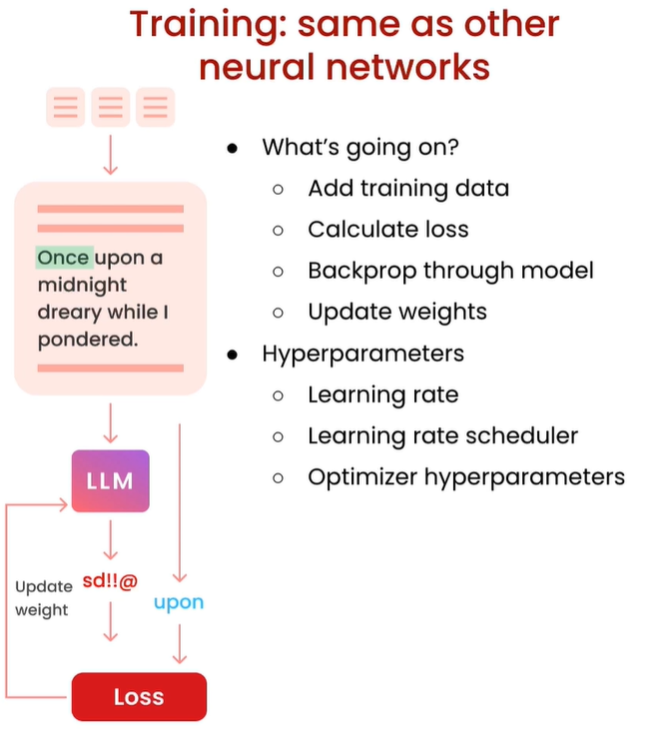

In [31]:
import datasets
import tempfile
import logging
import random
!pip install config
import config
import os
import yaml
import time
import torch
import transformers
import pandas as pd
!pip install jsonlines
import jsonlines

!pip install utils
from utils import *
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
from transformers import TrainingArguments
from transformers import AutoModelForCausalLM


logger = logging.getLogger(__name__)
global_config = None

#### Load dataset

In [32]:
# Not use Huggingface
dataset_name = "lamini_docs.jsonl"
dataset_path = f"/content/{dataset_name}"
use_hf = False

In [33]:
# Use Huggingface
dataset_path = "lamini/lamini_docs"
use_hf = True

#### Tokenize, Pad & Split train/test sets

In [35]:
model_name = "EleutherAI/pythia-70m"

In [36]:
#
training_config = {
    "model": {
        "pretrained_name": model_name,
        "max_length" : 2048
    },
    "datasets": {
        "use_hf": use_hf,
        "path": dataset_path
    },
    "verbose": True
}

In [37]:
'''
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token


def tokenize_and_split_data(config, tokenizer):
    """
    Tokenize and split a dataset into training and testing sets.

    Parameters:
    - config (dict): Configuration dictionary containing model and dataset information.
    - tokenizer: Hugging Face tokenizer object.

    Returns:
    - train_dataset: Tokenized and split training dataset.
    - test_dataset: Tokenized and split testing dataset.
    """

    # Split the dataset into training and testing sets
    split_dataset = tokenized_dataset.train_test_split(test_size=0.1, shuffle=True, seed=123)
    # tokenized_dataset was already defined above

    return train_dataset, test_dataset
'''


split_dataset = tokenized_dataset.train_test_split(test_size=0.1, shuffle=True, seed=123)

# split_dataset is a Hugging Face DatasetDict
train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

print(train_dataset)
print(test_dataset)

Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1260
})
Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 140
})


#### Load base model

In [38]:
# Specify model
model_name = "EleutherAI/pythia-70m"
base_model = AutoModelForCausalLM.from_pretrained(model_name)

In [39]:
device_count = torch.cuda.device_count()
if device_count > 0:
    logger.debug("Select GPU device")
    device = torch.device("cuda")
else:
    logger.debug("Select CPU device")
    device = torch.device("cpu")

In [40]:
base_model.to(device) # put the model to CPU or GPU

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

In [41]:
def inference(text, model, tokenizer, max_input_tokens=1000, max_output_tokens=100):
  # Tokenize
  input_ids = tokenizer.encode(
          text,
          return_tensors="pt",
          truncation=True,
          max_length=max_input_tokens
  )

  # Generate
  device = model.device
  generated_tokens_with_prompt = model.generate(
    input_ids=input_ids.to(device),
    max_length=max_output_tokens
  )

  # Decode
  generated_text_with_prompt = tokenizer.batch_decode(generated_tokens_with_prompt, skip_special_tokens=True)

  # Strip the prompt
  generated_text_answer = generated_text_with_prompt[0][len(text):]

  return generated_text_answer

In [42]:
# Try the base model
test_text = test_dataset[0]['question']
print("Question input (test):", test_text)
print(f"Correct answer from Lamini docs: {test_dataset[0]['answer']}")
print("Model's answer: ")
print(inference(test_text, base_model, tokenizer))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Question input (test): Can Lamini generate technical documentation or user manuals for software projects?
Correct answer from Lamini docs: Yes, Lamini can generate technical documentation and user manuals for software projects. It uses natural language generation techniques to create clear and concise documentation that is easy to understand for both technical and non-technical users. This can save developers a significant amount of time and effort in creating documentation, allowing them to focus on other aspects of their projects.
Model's answer: 


I have a question about the following:

How do I get the correct documentation to work?

A:

I think you need to use the following code:

A:

You can use the following code to get the correct documentation.

A:

You can use the following code to get the correct documentation.

A:

You can use the following


#### Setup training

In [59]:
# max number of training steps
max_steps = 3

In [61]:
# Name the trained model
trained_model_name = f"lamini_docs_{max_steps}_steps"
output_dir = trained_model_name

In [60]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

import torch
!pip install datasets transformers
from transformers import Trainer
from transformers import TrainingArguments

training_args = TrainingArguments(

  # Learning rate
  learning_rate=1.0e-5,

  # Number of training epochs
  num_train_epochs=1,

  # Max steps to train for (each step is a batch of data)
  # Overrides num_train_epochs, if not -1
  max_steps=max_steps,


  # Batch size for training
  per_device_train_batch_size=1,

  # Directory to save model checkpoints
  output_dir=output_dir,

  # Other arguments
  overwrite_output_dir=False, # Overwrite the content of the output directory
  disable_tqdm=False, # Disable progress bars
  eval_steps=120, # Number of update steps between two evaluations
  save_steps=120, # After # steps model is saved
  warmup_steps=1, # Number of warmup steps for learning rate scheduler
  per_device_eval_batch_size=1, # Batch size for evaluation
  evaluation_strategy="steps",
  logging_strategy="steps",
  logging_steps=1,
  optim="adafactor",
  gradient_accumulation_steps = 4,
  gradient_checkpointing=False,

  # Parameters for early stopping
  load_best_model_at_end=True,
  save_total_limit=1,
  metric_for_best_model="eval_loss",
  greater_is_better=False
)

In [49]:
# Show the model's ops
model_flops = (
  base_model.floating_point_ops(
    {
       "input_ids": torch.zeros(
           (1, training_config["model"]["max_length"])
      )
    }
  )
  * training_args.gradient_accumulation_steps
)

print(base_model)
print("Memory footprint", base_model.get_memory_footprint() / 1e9, "GB")
print("Flops", model_flops / 1e9, "GFLOPs")

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

In [62]:
trainer = Trainer(
    model=base_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

#### Train

In [63]:
training_output = trainer.train()

Step,Training Loss,Validation Loss


#### Save model locally

In [64]:
save_dir = f'{output_dir}/final'

trainer.save_model(save_dir)
print("Saved model to:", save_dir)

Saved model to: lamini_docs_3_steps/final


In [65]:
finetuned_slightly_model = AutoModelForCausalLM.from_pretrained(save_dir, local_files_only=True)

In [66]:
finetuned_slightly_model.to(device)

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

#### Run slightly trained model

In [67]:
test_question = test_dataset[0]['question']
print("Question input (test):", test_question)

print("Finetuned slightly model's answer: ")
print(inference(test_question, finetuned_slightly_model, tokenizer))

# Improved performance

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Question input (test): Can Lamini generate technical documentation or user manuals for software projects?
Finetuned slightly model's answer: 
Yes, Lamini can generate technical documentation or user manuals for software projects. This can be achieved through the use of a combination of technical documentation and user manuals. Additionally, Lamini can generate technical documentation or user manuals for software projects. Additionally, Lamini can generate technical documentation or user manuals for software projects. Additionally, Lamini can generate technical documentation or user manuals for software projects


In [68]:
test_answer = test_dataset[0]['answer']
print("Target answer output (test):", test_answer)

Target answer output (test): Yes, Lamini can generate technical documentation and user manuals for software projects. It uses natural language generation techniques to create clear and concise documentation that is easy to understand for both technical and non-technical users. This can save developers a significant amount of time and effort in creating documentation, allowing them to focus on other aspects of their projects.


#### Run same model that has been trained for 2 epochs

In [69]:
finetuned_longer_model = AutoModelForCausalLM.from_pretrained("lamini/lamini_docs_finetuned")
tokenizer = AutoTokenizer.from_pretrained("lamini/lamini_docs_finetuned")

finetuned_longer_model.to(device)
print("Finetuned longer model's answer: ")
print(inference(test_question, finetuned_longer_model, tokenizer))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Finetuned longer model's answer: 
Yes, Lamini can generate technical documentation or user manuals for software projects. This can be achieved by providing a prompt for a specific technical question or question to the LLM Engine, or by providing a prompt for a specific technical question or question. Additionally, Lamini can be trained on specific technical questions or questions to help users understand the process and provide feedback to the LLM Engine. Additionally, Lamini


### Instruction Tuning: Evaluation & Iteration

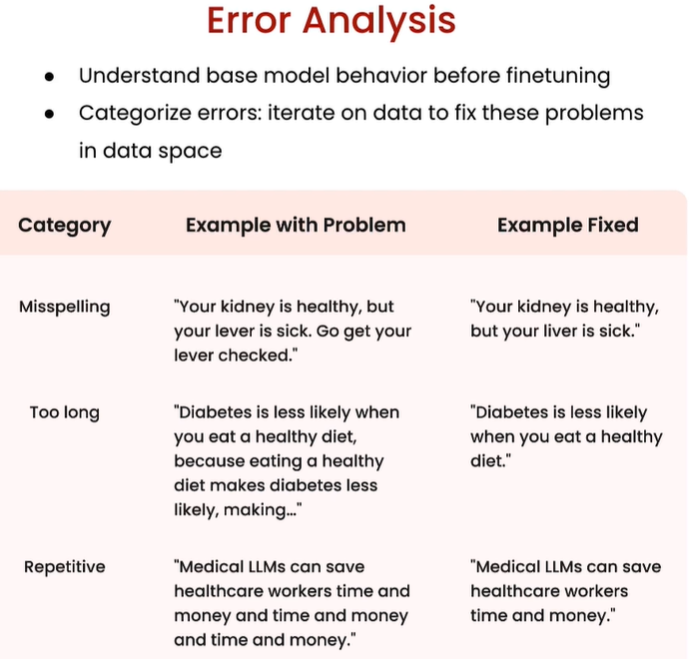

In [70]:
import datasets
import tempfile
import logging
import random
import config
import os
import yaml
import logging
import difflib
import pandas as pd

import transformers
import datasets
import torch

from tqdm import tqdm
from utils import *
from transformers import AutoTokenizer, AutoModelForCausalLM

logger = logging.getLogger(__name__)
global_config = None

In [71]:
dataset = datasets.load_dataset("lamini/lamini_docs")

# pull up test set
test_dataset = dataset["test"]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1260 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/140 [00:00<?, ? examples/s]

In [72]:
print(test_dataset[0]["question"])
print(test_dataset[0]["answer"])

Can Lamini generate technical documentation or user manuals for software projects?
Yes, Lamini can generate technical documentation and user manuals for software projects. It uses natural language generation techniques to create clear and concise documentation that is easy to understand for both technical and non-technical users. This can save developers a significant amount of time and effort in creating documentation, allowing them to focus on other aspects of their projects.


In [73]:
model_name = "lamini/lamini_docs_finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [74]:
# Set up a very very basic evaluation function
def is_exact_match(a, b):
    return a.strip() == b.strip()

In [75]:
model.eval()

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

In [76]:
def inference(text, model, tokenizer, max_input_tokens=1000, max_output_tokens=100):
  # Tokenize
  tokenizer.pad_token = tokenizer.eos_token
  input_ids = tokenizer.encode(
      text,
      return_tensors="pt",
      truncation=True,
      max_length=max_input_tokens
  )

  # Generate
  device = model.device
  generated_tokens_with_prompt = model.generate(
    input_ids=input_ids.to(device),
    max_length=max_output_tokens
  )

  # Decode
  generated_text_with_prompt = tokenizer.batch_decode(generated_tokens_with_prompt, skip_special_tokens=True)

  # Strip the prompt
  generated_text_answer = generated_text_with_prompt[0][len(text):]

  return generated_text_answer

In [77]:
# Run model and compare with expected answer
test_question = test_dataset[0]["question"]
generated_answer = inference(test_question, model, tokenizer)
print(test_question)
print(generated_answer)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Can Lamini generate technical documentation or user manuals for software projects?
Yes, Lamini can generate technical documentation or user manuals for software projects. This can be achieved by providing a prompt for a specific technical question or question to the LLM Engine, or by providing a prompt for a specific technical question or question. Additionally, Lamini can be trained on specific technical questions or questions to help users understand the process and provide feedback to the LLM Engine. Additionally, Lamini


In [78]:
answer = test_dataset[0]["answer"]
print(answer)

Yes, Lamini can generate technical documentation and user manuals for software projects. It uses natural language generation techniques to create clear and concise documentation that is easy to understand for both technical and non-technical users. This can save developers a significant amount of time and effort in creating documentation, allowing them to focus on other aspects of their projects.


In [79]:
exact_match = is_exact_match(generated_answer, answer)
print(exact_match)

# the output does not match expected answer

False


In [80]:
# Run over entire dataset
n = 10
metrics = {'exact_matches': []}
predictions = []
for i, item in tqdm(enumerate(test_dataset)):
    print("i Evaluating: " + str(item))
    question = item['question']
    answer = item['answer']

    try:
      predicted_answer = inference(question, model, tokenizer)
    except:
      continue
    predictions.append([predicted_answer, answer])

    #fixed: exact_match = is_exact_match(generated_answer, answer)
    exact_match = is_exact_match(predicted_answer, answer)
    metrics['exact_matches'].append(exact_match)

    if i > n and n != -1:
      break
print('Number of exact matches: ', sum(metrics['exact_matches']))

0it [00:00, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


i Evaluating: {'question': 'Can Lamini generate technical documentation or user manuals for software projects?', 'answer': 'Yes, Lamini can generate technical documentation and user manuals for software projects. It uses natural language generation techniques to create clear and concise documentation that is easy to understand for both technical and non-technical users. This can save developers a significant amount of time and effort in creating documentation, allowing them to focus on other aspects of their projects.', 'input_ids': [5804, 418, 4988, 74, 6635, 7681, 10097, 390, 2608, 11595, 84, 323, 3694, 6493, 32, 4374, 13, 418, 4988, 74, 476, 6635, 7681, 10097, 285, 2608, 11595, 84, 323, 3694, 6493, 15, 733, 4648, 3626, 3448, 5978, 5609, 281, 2794, 2590, 285, 44003, 10097, 326, 310, 3477, 281, 2096, 323, 1097, 7681, 285, 1327, 14, 48746, 4212, 15, 831, 476, 5321, 12259, 247, 1534, 2408, 273, 673, 285, 3434, 275, 6153, 10097, 13, 6941, 731, 281, 2770, 327, 643, 7794, 273, 616, 6493, 1

1it [00:04,  4.00s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


i Evaluating: {'question': 'How do I include my API key in the Authorization HTTP header?', 'answer': 'The Authorization HTTP header should include the API key in the following format: Authorization: Bearer <YOUR-KEY-HERE>.', 'input_ids': [2347, 513, 309, 2486, 619, 8990, 2234, 275, 253, 10360, 1320, 17607, 10478, 32, 510, 10360, 1320, 17607, 10478, 943, 2486, 253, 8990, 2234, 275, 253, 1563, 5981, 27, 10360, 1320, 27, 2325, 12287, 654, 58, 11862, 14, 13888, 14, 41, 8147, 13208], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [2347, 513, 309, 2486, 619, 8990, 2234, 275, 253, 10360, 1320, 17607, 10478, 32, 510, 10360, 1320, 17607, 10478, 943, 2486, 253, 8990, 2234, 275, 253, 1563, 5981, 27, 10360, 1320, 27, 2325, 12287, 654, 58, 11862, 14, 13888, 14, 41, 8147, 13208]}


2it [00:07,  3.50s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


i Evaluating: {'question': "Is there a section explaining the code's approach to handling versioning and compatibility?", 'answer': 'Yes, the code includes a version parameter in the FeedbackOperation class constructor, which allows for handling versioning and compatibility.', 'input_ids': [2513, 627, 247, 2593, 15571, 253, 2127, 434, 2746, 281, 10885, 2715, 272, 285, 22862, 32, 4374, 13, 253, 2127, 3797, 247, 2715, 4764, 275, 253, 34600, 2135, 17547, 966, 16757, 13, 534, 4483, 323, 10885, 2715, 272, 285, 22862, 15], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [2513, 627, 247, 2593, 15571, 253, 2127, 434, 2746, 281, 10885, 2715, 272, 285, 22862, 32, 4374, 13, 253, 2127, 3797, 247, 2715, 4764, 275, 253, 34600, 2135, 17547, 966, 16757, 13, 534, 4483, 323, 10885, 2715, 272, 285, 22862, 15]}


3it [00:11,  4.02s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


i Evaluating: {'question': 'Is there a community or support forum available for Lamini users?', 'answer': 'Yes, there is a community forum available for Lamini users. The Lamini community forum can be accessed through the Lamini website and provides a platform for users to ask questions, share ideas, and collaborate with other developers using the library. Additionally, the Lamini team is active on the forum and provides support and guidance to users as needed.', 'input_ids': [2513, 627, 247, 3114, 390, 1329, 12209, 2130, 323, 418, 4988, 74, 4212, 32, 4374, 13, 627, 310, 247, 3114, 12209, 2130, 323, 418, 4988, 74, 4212, 15, 380, 418, 4988, 74, 3114, 12209, 476, 320, 19197, 949, 253, 418, 4988, 74, 4422, 285, 3400, 247, 5147, 323, 4212, 281, 1642, 3533, 13, 3894, 5697, 13, 285, 42124, 342, 643, 12259, 970, 253, 6335, 15, 9157, 13, 253, 418, 4988, 74, 2285, 310, 3939, 327, 253, 12209, 285, 3400, 1329, 285, 12925, 281, 4212, 347, 3058, 15], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

4it [00:16,  4.49s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


i Evaluating: {'question': 'Can the Lamini library be utilized for text completion or auto-completion tasks, such as filling in missing words or predicting the next word in a sentence?', 'answer': 'The Lamini library is not specifically designed for text completion or auto-completion tasks. However, it can be used for language modeling and generating text based on a given prompt.', 'input_ids': [5804, 253, 418, 4988, 74, 6335, 320, 12845, 323, 2505, 12240, 390, 6753, 14, 45634, 8892, 13, 824, 347, 12868, 275, 5816, 3000, 390, 21565, 253, 1735, 3159, 275, 247, 6197, 32, 510, 418, 4988, 74, 6335, 310, 417, 5742, 4158, 323, 2505, 12240, 390, 6753, 14, 45634, 8892, 15, 1723, 13, 352, 476, 320, 908, 323, 3448, 14053, 285, 11365, 2505, 1754, 327, 247, 1677, 8959, 15], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'la

5it [00:20,  4.20s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


i Evaluating: {'question': 'Are there any costs associated with using Lamini for machine learning tasks, and how does the pricing structure work?', 'answer': 'Lamini offers both free and paid plans for using their machine learning services. The free plan includes limited access to their models and data generator, while the paid plans offer more advanced features and higher usage limits. The pricing structure is based on a pay-as-you-go model, where users are charged based on the number of API requests and data processed. Lamini also offers custom enterprise plans for larger organizations with specific needs.', 'input_ids': [6723, 627, 667, 4815, 2330, 342, 970, 418, 4988, 74, 323, 5145, 4715, 8892, 13, 285, 849, 1057, 253, 20910, 2605, 789, 32, 45, 4988, 74, 6131, 1097, 1959, 285, 5087, 5827, 323, 970, 616, 5145, 4715, 3238, 15, 380, 1959, 2098, 3797, 3710, 2289, 281, 616, 3210, 285, 941, 14156, 13, 1223, 253, 5087, 5827, 3959, 625, 7269, 3386, 285, 2169, 10393, 7787, 15, 380, 20910, 2

6it [00:23,  3.87s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


i Evaluating: {'question': 'How do I instantiate the LLM engine using the Lamini Python package?', 'answer': 'You can instantiate the LLM engine using the llama module in the Lamini Python package. To do this, you need to import the LLM engine from the llama module, like this: from llama import LLM.', 'input_ids': [2347, 513, 309, 8164, 4513, 253, 21708, 46, 3948, 970, 253, 418, 4988, 74, 13814, 5522, 32, 1394, 476, 8164, 4513, 253, 21708, 46, 3948, 970, 253, 26198, 2902, 6333, 275, 253, 418, 4988, 74, 13814, 5522, 15, 1916, 513, 436, 13, 368, 878, 281, 1395, 253, 21708, 46, 3948, 432, 253, 26198, 2902, 6333, 13, 751, 436, 27, 432, 26198, 2902, 1395, 21708, 46, 15], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [2347, 513, 309, 8164, 4513, 253, 21708, 46, 3948, 970, 253, 418, 4988, 74, 13814, 5522, 32, 1394

7it [00:26,  3.33s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


i Evaluating: {'question': 'Does Lamini provide any mechanisms for model compression or optimization to reduce memory footprint?', 'answer': 'Yes, Lamini provides mechanisms for model compression and optimization to reduce memory footprint. These include techniques such as pruning, quantization, and distillation, which can significantly reduce the size of the model while maintaining its performance. Additionally, Lamini offers support for deploying customized LLMs on edge devices with limited resources, such as mobile phones or IoT devices, through techniques such as model quantization and on-device inference.', 'input_ids': [10795, 418, 4988, 74, 2085, 667, 6297, 323, 1566, 13800, 390, 13757, 281, 4796, 3541, 33257, 32, 4374, 13, 418, 4988, 74, 3400, 6297, 323, 1566, 13800, 285, 13757, 281, 4796, 3541, 33257, 15, 2053, 2486, 5609, 824, 347, 819, 25004, 13, 36643, 13, 285, 940, 21755, 13, 534, 476, 3012, 4796, 253, 1979, 273, 253, 1566, 1223, 11850, 697, 3045, 15, 9157, 13, 418, 4988, 

8it [00:28,  2.99s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


i Evaluating: {'question': 'How does the performance of LLMs trained using Lamini compare to models fine-tuned with traditional approaches?', 'answer': 'According to the information provided, Lamini allows developers to train high-performing LLMs on large datasets with just a few lines of code from the Lamini library. The optimizations in this library reach far beyond what’s available to developers now, from more challenging optimizations like RLHF to simpler ones like reducing hallucinations. While there is no direct comparison to traditional approaches mentioned, Lamini aims to make training LLMs faster and more accessible to a wider range of developers.', 'input_ids': [2347, 1057, 253, 3045, 273, 21708, 12822, 10166, 970, 418, 4988, 74, 7277, 281, 3210, 4030, 14, 85, 37437, 342, 5899, 7274, 32, 7130, 281, 253, 1491, 2530, 13, 418, 4988, 74, 4483, 12259, 281, 6194, 1029, 14, 468, 14692, 21708, 12822, 327, 1781, 15302, 342, 816, 247, 1643, 3104, 273, 2127, 432, 253, 418, 4988, 74, 633

9it [00:30,  2.71s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


i Evaluating: {'question': 'Is there any support or community available to help me if I have questions or need assistance while using Lamini?', 'answer': 'Yes, there is a support community available to assist you with any questions or issues you may have while using Lamini. You can join the Lamini Discord server or reach out to the Lamini team directly for assistance.', 'input_ids': [2513, 627, 667, 1329, 390, 3114, 2130, 281, 1361, 479, 604, 309, 452, 3533, 390, 878, 8385, 1223, 970, 418, 4988, 74, 32, 4374, 13, 627, 310, 247, 1329, 3114, 2130, 281, 10073, 368, 342, 667, 3533, 390, 3374, 368, 778, 452, 1223, 970, 418, 4988, 74, 15, 1422, 476, 6604, 253, 418, 4988, 74, 15292, 636, 4771, 390, 3986, 562, 281, 253, 418, 4988, 74, 2285, 3587, 323, 8385, 15], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'l

10it [00:32,  2.55s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


i Evaluating: {'question': 'Are there any code samples illustrating how to implement custom logging handlers?', 'answer': 'Yes, the Python logging module documentation provides several examples of how to implement custom logging handlers. You can find them in the official documentation here: https://docs.python.org/3/howto/logging-cookbook.html#developing-new-handlers', 'input_ids': [6723, 627, 667, 2127, 3530, 34805, 849, 281, 3359, 2840, 20893, 40093, 32, 4374, 13, 253, 13814, 20893, 6333, 10097, 3400, 2067, 6667, 273, 849, 281, 3359, 2840, 20893, 40093, 15, 1422, 476, 1089, 731, 275, 253, 3565, 10097, 1060, 27, 5987, 1358, 13880, 15, 16659, 15, 2061, 16, 20, 16, 5430, 936, 16, 36193, 14, 29519, 3305, 15, 2974, 4, 16714, 272, 14, 1826, 14, 4608, 10787], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': 

11it [00:36,  2.93s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


i Evaluating: {'question': 'Are there any code samples illustrating how to handle authentication and authorization?', 'answer': 'Yes, there is a separate section in the documentation explaining authentication, for more information visit https://lamini-ai.github.io/auth/', 'input_ids': [6723, 627, 667, 2127, 3530, 34805, 849, 281, 6016, 19676, 285, 26239, 32, 4374, 13, 627, 310, 247, 4858, 2593, 275, 253, 10097, 15571, 19676, 13, 323, 625, 1491, 4143, 5987, 1358, 77, 4988, 74, 14, 2284, 15, 7280, 15, 900, 16, 14399, 16], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [6723, 627, 667, 2127, 3530, 34805, 849, 281, 6016, 19676, 285, 26239, 32, 4374, 13, 627, 310, 247, 4858, 2593, 275, 253, 10097, 15571, 19676, 13, 323, 625, 1491, 4143, 5987, 1358, 77, 4988, 74, 14, 2284, 15, 7280, 15, 900, 16, 14399, 16]}


11it [00:40,  3.70s/it]

Number of exact matches:  0


In [81]:
df = pd.DataFrame(predictions, columns=["predicted_answer", "target_answer"])
print(df)

                                     predicted_answer  \
0   Yes, Lamini can generate technical documentati...   
1   You can use the Authorization HTTP header to g...   
2   Lamini’s LLM Engine is a LLM Engine for develo...   
3   Yes, there is a community or support forum ava...   
4   Yes, the Lamini library can be utilized for te...   
5   Lamini is designed to be flexible and scalable...   
6   You can instantiate the LLM engine using the L...   
7   Yes, Lamini provides mechanisms for compressio...   
8   The performance of LLMs trained using Lamini c...   
9   Yes, there is a support and community availabl...   
10  Yes, there are some code samples available in ...   
11  Yes, there are some code samples available tha...   

                                        target_answer  
0   Yes, Lamini can generate technical documentati...  
1   The Authorization HTTP header should include t...  
2   Yes, the code includes a version parameter in ...  
3   Yes, there is a community foru

#### Evaluate all data

In [82]:
evaluation_dataset_path = "lamini/lamini_docs_evaluation"
evaluation_dataset = datasets.load_dataset(evaluation_dataset_path)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/139 [00:00<?, ? examples/s]

In [83]:
pd.DataFrame(evaluation_dataset)

,train
0,"{'predicted_answer': 'Yes, Lamini can generate..."
1,{'predicted_answer': 'You can use the Authoriz...
2,{'predicted_answer': 'Lamini’s LLM Engine is a...
3,"{'predicted_answer': 'Yes, there is a communit..."
4,"{'predicted_answer': 'Yes, the Lamini library ..."
...,...
134,"{'predicted_answer': 'Yes, Lamini has the abil..."
135,{'predicted_answer': 'I wish! This documentati...
136,"{'predicted_answer': 'Yes, Lamini can generate..."
137,"{'predicted_answer': 'Yes, the documentation h..."


#### ARC benchmark

In [ ]:
# Evaluate the tuned model based on grade-school student question
# Not very useful for specialized finetuned model
!python lm-evaluation-harness/main.py --model hf-causal --model_args pretrained=lamini/lamini_docs_finetuned --tasks arc_easy --device cpu

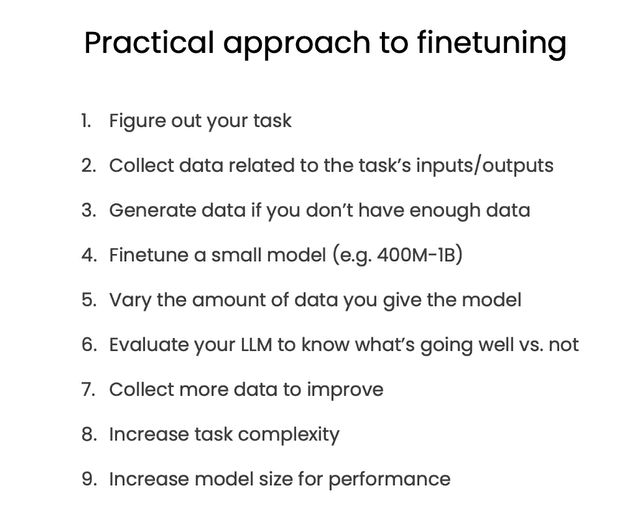


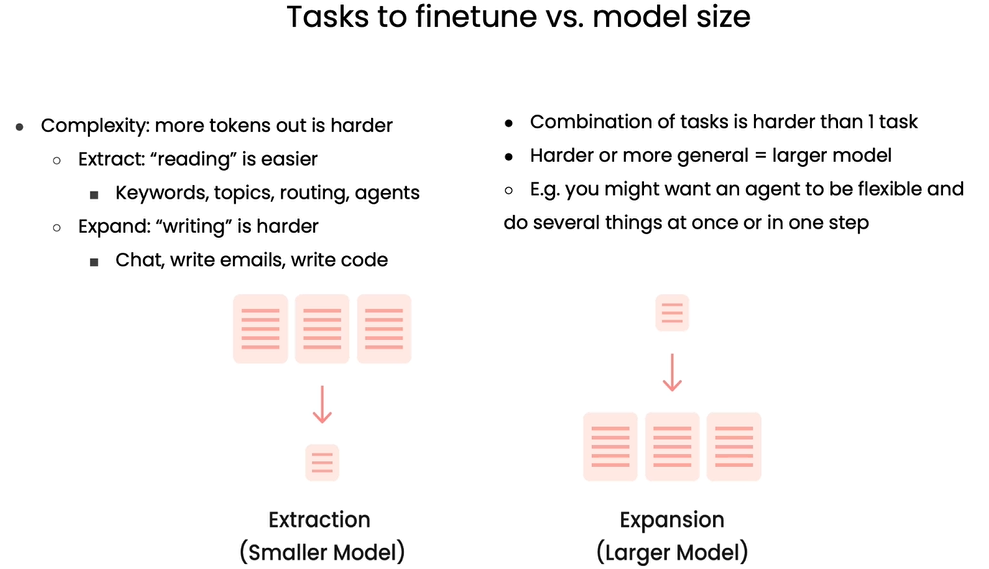

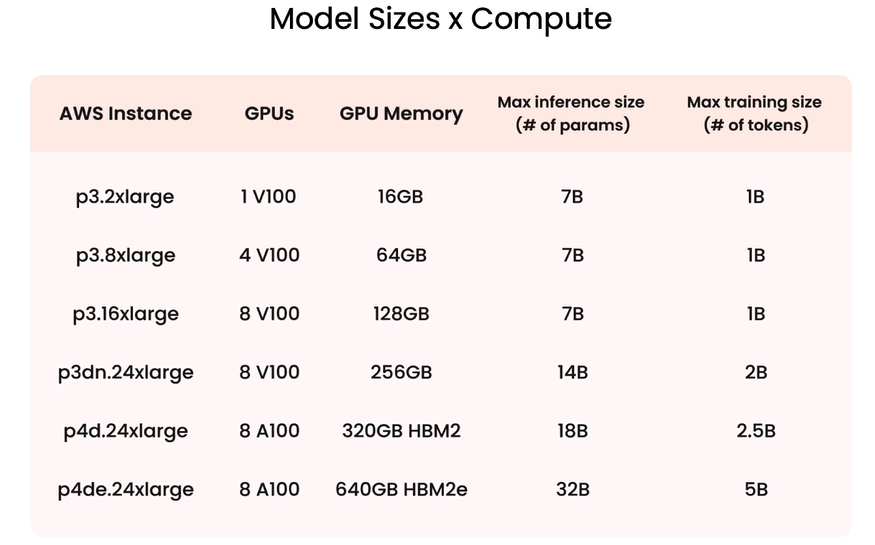

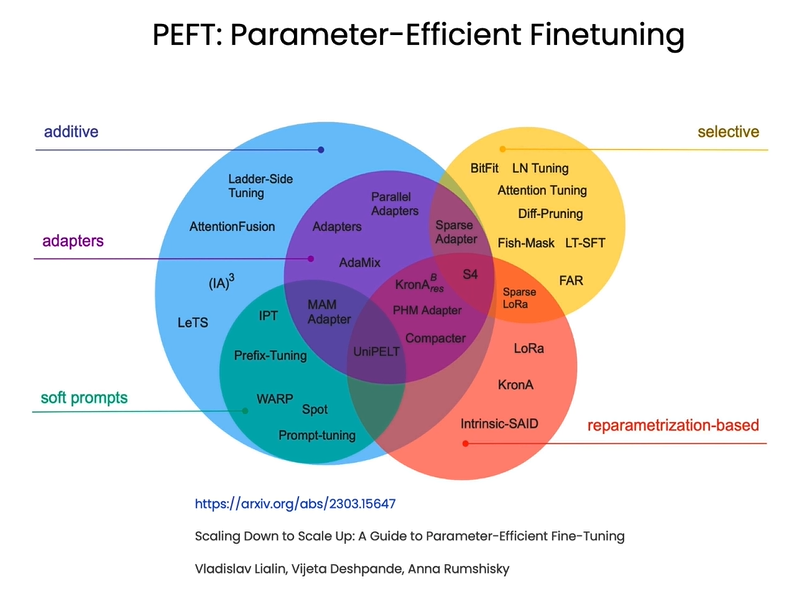


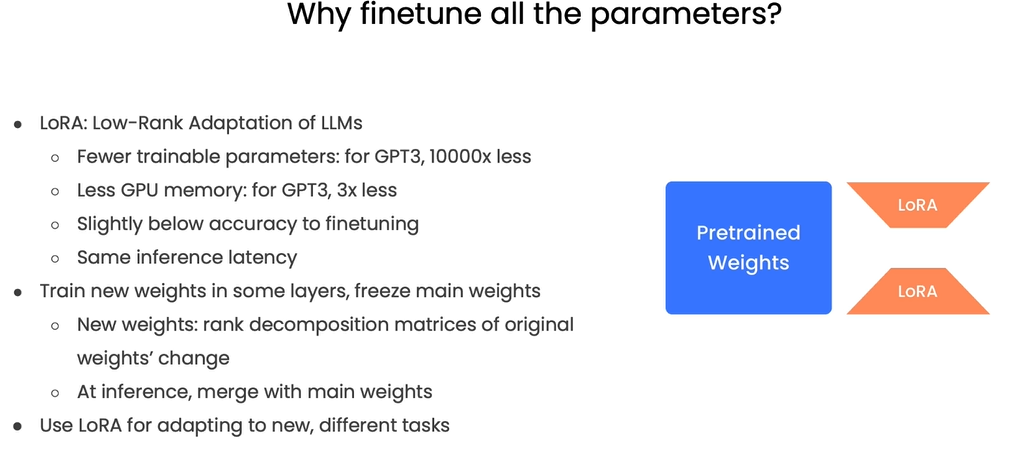

